In [1]:
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import warnings
import sys
warnings.simplefilter(action='ignore')
sns.set(style='whitegrid', font_scale=1.3, palette='Set2')
%matplotlib inline

In [131]:
image_name = "1c.png"

In [132]:
img = Image.open(image_name)
image_sequence = img.getdata()
ar = np.array(image_sequence)

In [3]:
raw_data = np.asarray(img).sum(axis=2).T
raw_data[raw_data == 1020] = 0
raw_data[raw_data == 255] = 1
#преобразуем ячейки
raw_data.shape

(564, 392)

In [110]:
#рассчитаем ширину кисти
def get_width(ar):
    min_srez = np.ones(50)*ar.shape[1]
    ind = 0
    for  i in np.linspace(ar.shape[0]/10, ar.shape[0]*0.89, 50, dtype=int):
        mcc = 1
        for j in range(1, ar.shape[1]):
            if (ar[i][j] == 1 and ar[i][j-1] == ar[i][j]):
                mcc+=1
            if (ar[i][j] == 0 and ar[i][j-1] != ar[i][j]):
                min_srez[ind] = min(min_srez[ind], mcc)
                mcc = 1
        ind+=1
    return int(np.median(min_srez))

In [112]:
pixel_width = get_width(raw_data)
print(pixel_width)

5


In [7]:
#функция для удаления граничных пикселей
def cut_border(tmp):
    tt = np.zeros(tmp.shape, dtype=int)
    print(tt.shape)
    for i in range(1, tt.shape[0]-1):
        for j in range(1, tt.shape[1]-1):
            if tmp[i+1][j]==1 and tmp[i-1][j]==1 and tmp[i][j+1]==1 and tmp[i][j-1]==1:
                tt[i][j] = int(1)
    return tt.copy()

In [9]:
#сделаем рубра толщиной 1
tmp = raw_data.copy()
for _ in range (pixel_width//2):
    tmp = cut_border(tmp)
tri = tmp.copy()
#удалим ребра
vertexes = cut_border(tri)

(564, 392)
(564, 392)
(564, 392)


In [ ]:
Посмотрим на графиках, что получилось

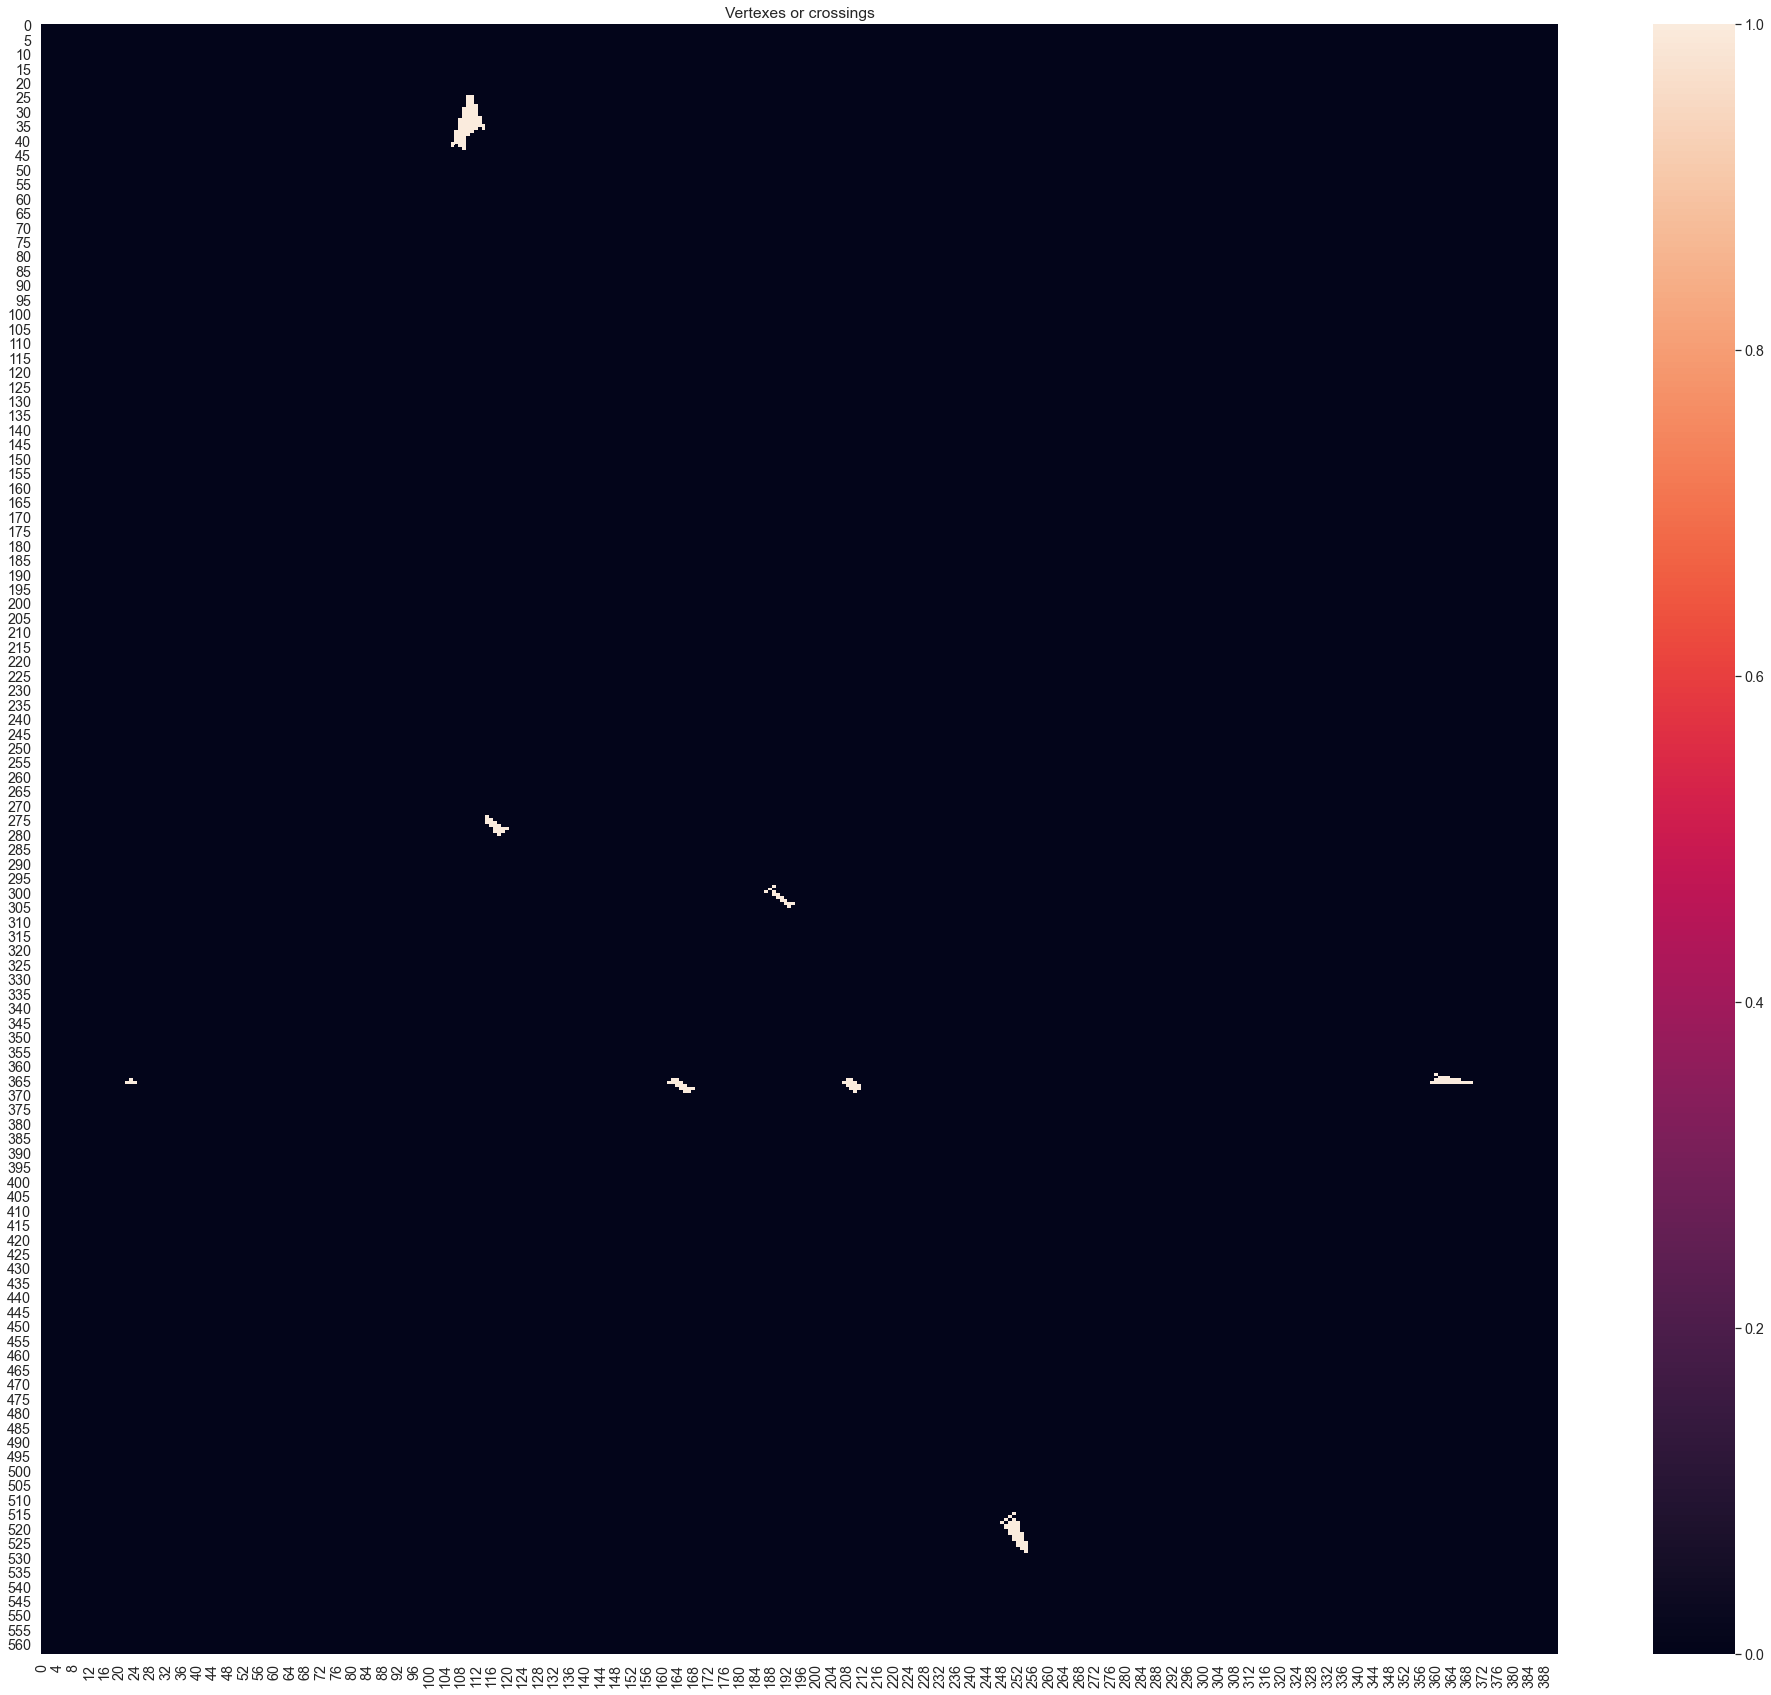

In [114]:
plt.figure(figsize=(34, 30))
sns.heatmap(vertexes)
plt.title('Vertexes or crossings')
plt.show()

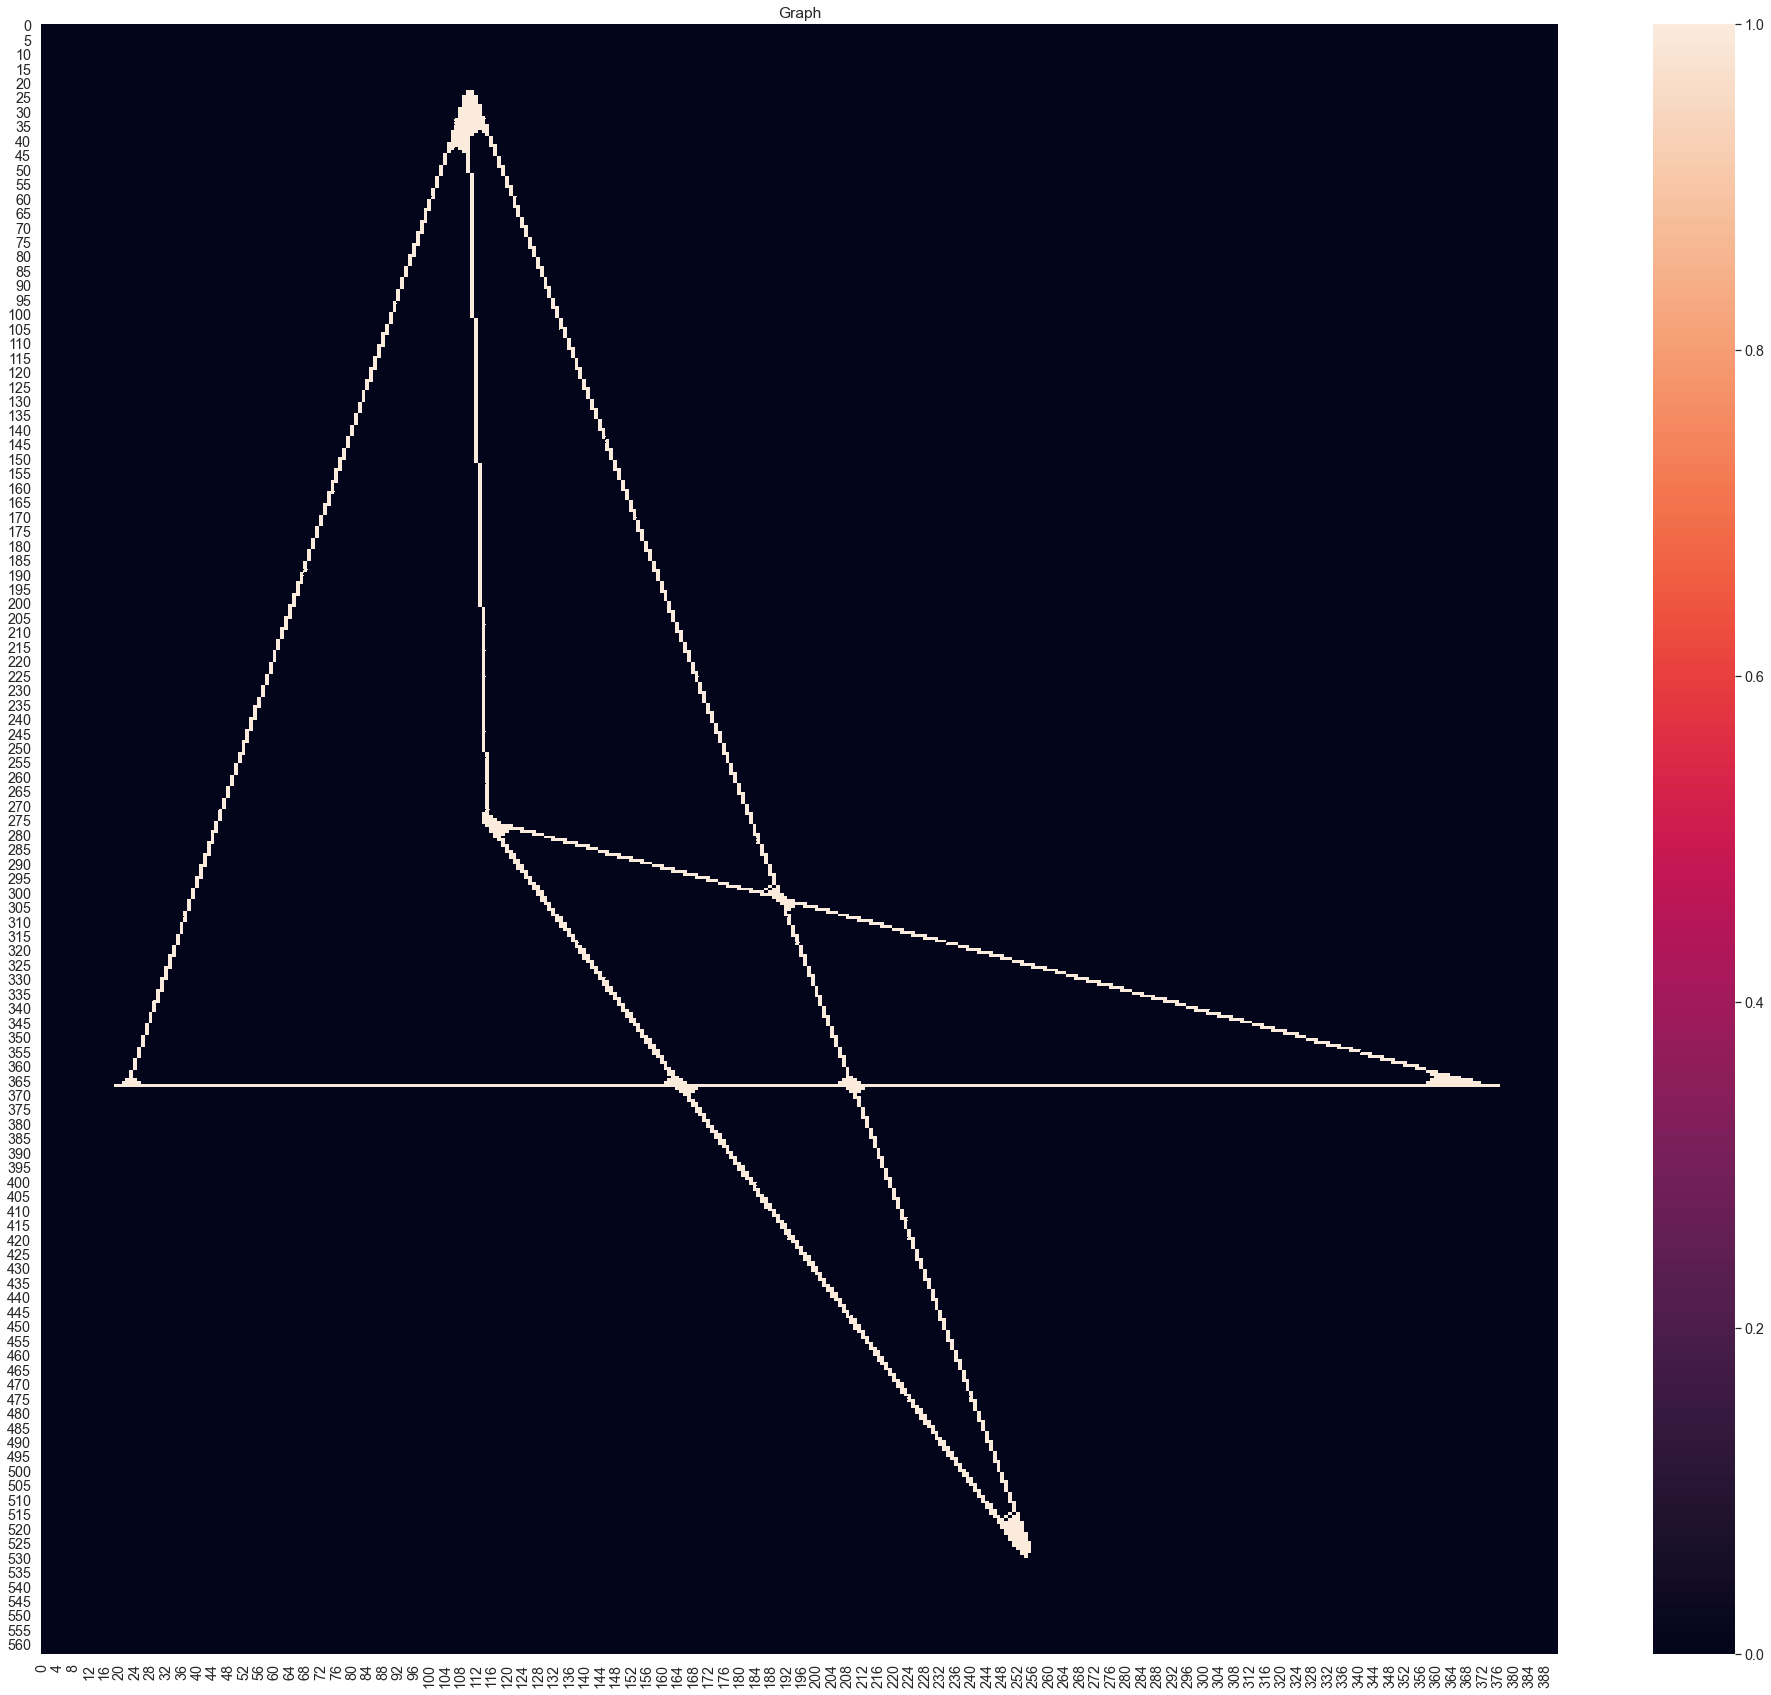

In [115]:
plt.figure(figsize=(34, 30))
sns.heatmap(tri)
plt.title('Graph')
plt.show()

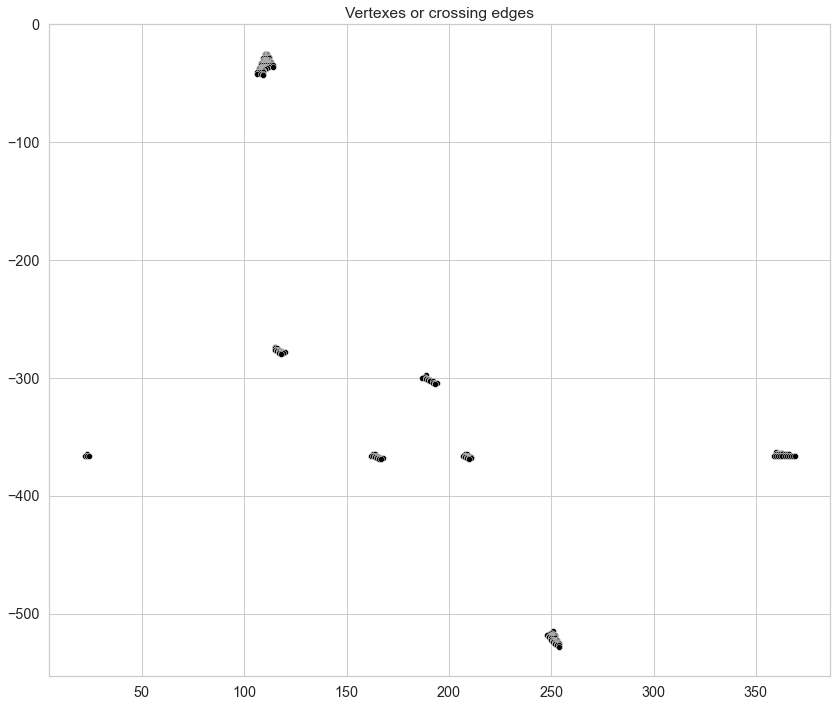

In [116]:
plt.figure(figsize=(14, 12))

y, x = vertexes.nonzero()
plt.title('Vertexes or crossing edges')
sns.scatterplot(x, -y, color = 'black')
plt.show()

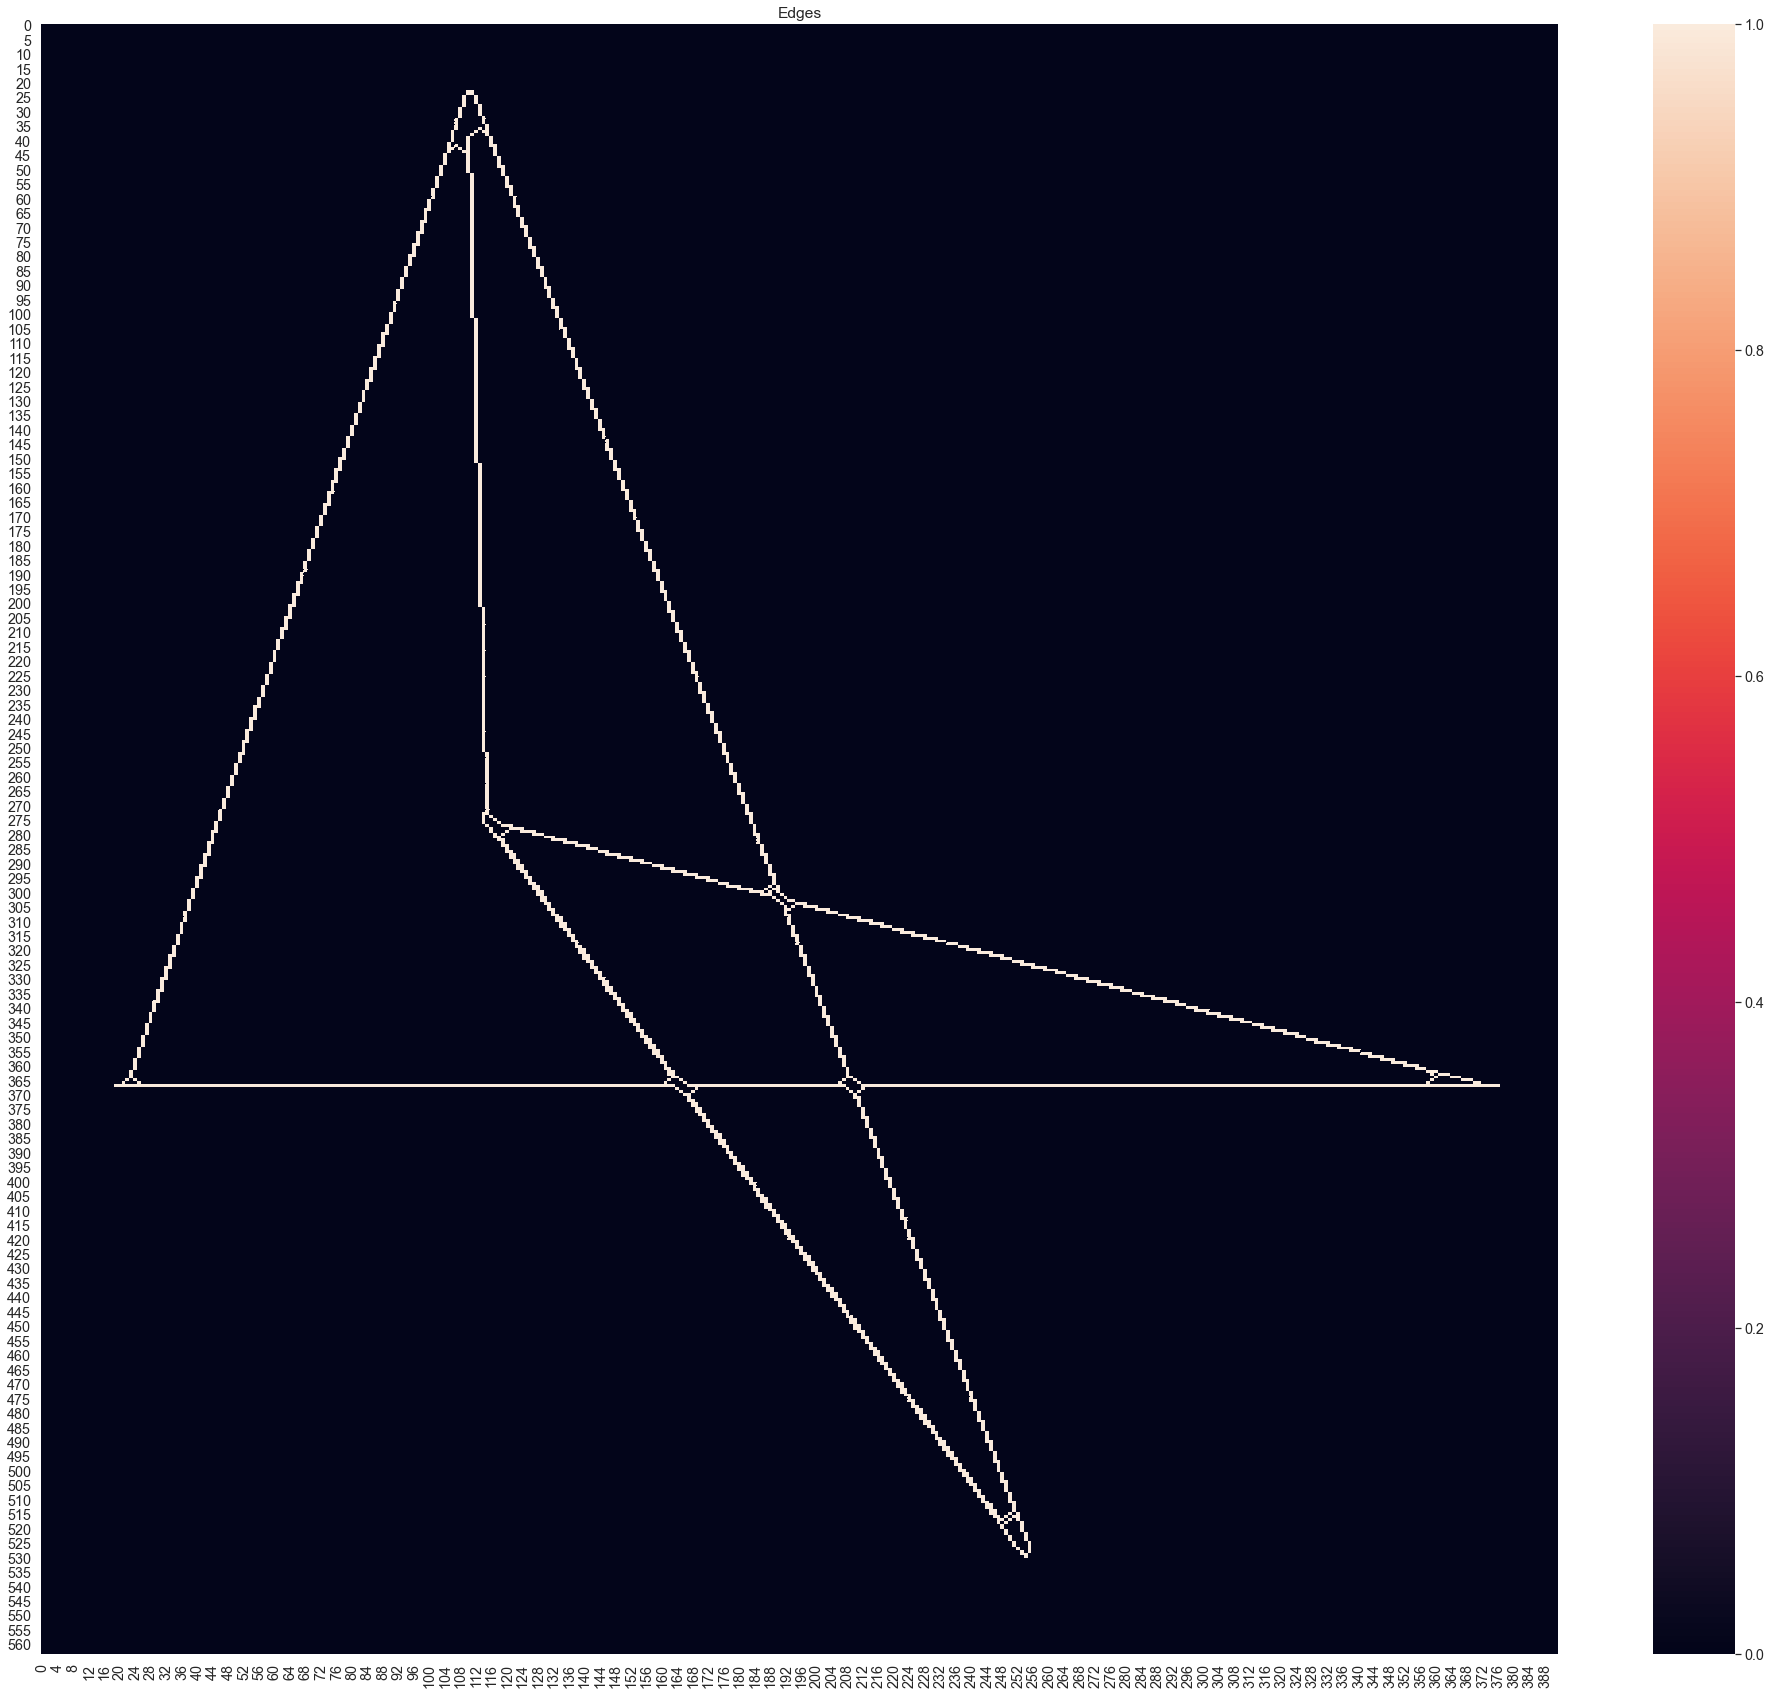

In [117]:
edges = tri.copy()

edges[vertexes == 1] = 0
edges_1 = edges.nonzero()
plt.figure(figsize=(34, 30))
sns.heatmap(edges)
plt.title('Edges')
plt.show()

In [118]:
#функция расстояния, необходимая для поиска близких точек
def get_dist(x1, y1, x2, y2):
    return ((x1-x2)**2+(y1-y2)**2)**0.5

In [120]:
#получим координаты точек вершин
vy, vx = vertexes.nonzero()

In [121]:
#оставим для каждой вершины только точку -- среднее среди точек, принадлежащих ей на картинке
alr = set()
for j, i in zip(vy, vx):
    key = True
#     print(i, j)
    for ii, jj in alr:
        if (get_dist(i, j, ii, jj) < 4*pixel_width):
            key = False
    if key:
        alr.add((i, j))

V = []
for ai, aj in alr:
    nearest = []
    for j, i in zip(vy, vx):
        if (get_dist(i, j, ai, aj) < 4*pixel_width):
            nearest.append([i, j])
    V.append(np.array(nearest).mean(axis=0))
V = np.array(V)

In [122]:
u_x = []
u_y = []
for i in V:
    u_x.append(i[0])
    u_y.append(i[1])

In [20]:
e_x = []
e_y = []
for i, j in zip(edges_1[0], edges_1[1]):
    e_x.append(j)
    e_y.append(i)

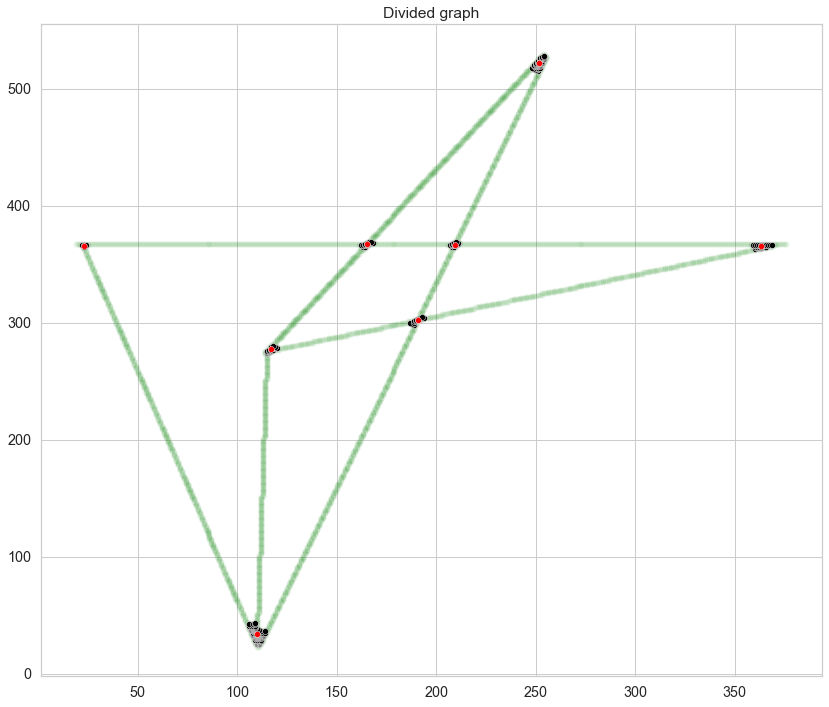

In [124]:
#Посмотрим, что получилось
plt.figure(figsize=(14, 12))

y, x = vertexes.nonzero()

sns.scatterplot(e_x, e_y, color = 'green', alpha = 0.1)
sns.scatterplot(x, y, color = 'black')
sns.scatterplot(u_x, u_y, color = 'red')
plt.title('Divided graph')
plt.show()

In [128]:
#проверяем, окружает ли данную точку данный массив точек
def check_surrounded(point, neighboursx, neighboursy):
    if (len(neighboursx))<4:
        return False
    if (len(neighboursx))>4:
        neighboursx=neighboursx[1:6]
        neighboursy=neighboursy[1:6]
    neighboursx -= point[0]
    neighboursy -= point[1]
    neighbours = np.array([neighboursx, neighboursy])
#     print(neighbours)
    summed = neighbours[:, 0]+neighbours[:, 3]
    summed = np.append(summed, neighbours[:, 1]+neighbours[:, 2])
    return np.all(summed<1)

In [129]:
drx = []
dry = []
Drx = []
Dry = []
ans = 0
for xv, yv in V[:]:
#     print(xv, yv)
    for ex, ey in zip(e_x, e_y):
        if abs((get_dist(xv, yv, ex, ey)) - 3*pixel_width) < 0.4:  #берем точки лежащие на расстоянии ~15
            drx.append(ex) #сохраняем для каждой вершины
            dry.append(ey)
            Drx.append(ex) #сохраняем, чтобы показать на графике
            Dry.append(ey)
    if check_surrounded((xv, yv), drx, dry):
        ans += 1
    drx = []
    dry = []
print(ans)

3


$\uparrow$ Ответ

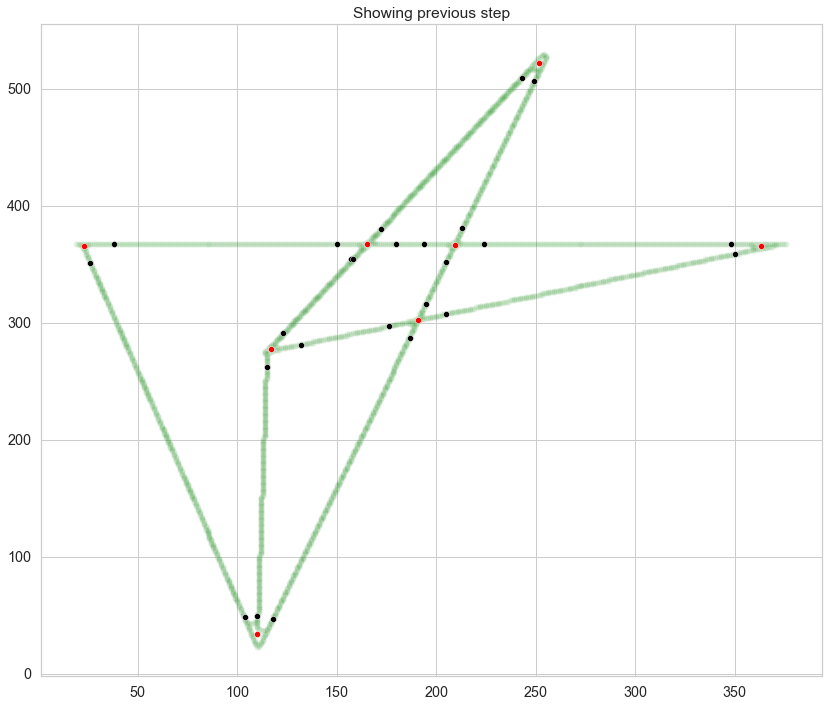

In [130]:
plt.figure(figsize=(14, 12))
y, x = vertexes.nonzero()
plt.title('Showing previous step')
sns.scatterplot(e_x, e_y, color = 'green', alpha = 0.1)
sns.scatterplot(Drx, Dry, color = 'black')
sns.scatterplot(u_x, u_y, color = 'red')
plt.show()